<a href="https://colab.research.google.com/github/tanvikurundkar/Pneumonia-Detection/blob/main/Tanvi_PneumoniaDetection_Section1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

This week, we'll be delving right into the projects. You and your group are going to build an AI tool that can help doctors tell if their patients have pneumonia. We'll start by understanding our problem, identifying:
* Who are our key stakeholders? (radiologists AND patients)
* What do they want to solve? (detecting pneumonia)
* What kind of data do they have? (x-ray images)

Once we have all of this information, we will take a step back and plan our approach to designing our medical imaging AI.

In today's notebook, we'll explore our data, practice some image manipulation techniques, and start creating an AI model!


In this notebook we'll be:
1.   Understanding medical imaging, pneumonia, and x-rays
2.   Understanding and visualizing our data
3.   Understanding how to apply ML to pneumonia prediction



In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)
  
class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry. 
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);


--2022-06-29 03:26:00--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40508 (40K) [text/csv]
Saving to: ‘metadata.csv.1’

metadata.csv.1      100%[===================>]  39.56K  --.-KB/s    in 0.001s  

2022-06-29 03:26:01 (40.9 MB/s) - ‘metadata.csv.1’ saved [40508/40508]

--2022-06-29 03:26:01--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapi

# Milestone 1. Understanding medical imaging, pneumonia, and x-rays


**Discuss: Who are Radiologists? What is Pneumonia?** 

## Exercise (Discussion)

If you have ever broken a bone, it is likely that you had an x-ray. 

![](http://www.seriousinjuryhelpline.co.uk/wp-content/uploads/2016/09/arm-break-320x320.jpg)

In [ ]:
#@title What part of your body was this x-ray was taken on? What happened to this body part? { display-mode: "form" }
BodyPart= "Arm" #@param ["Your answer","Leg","Lung","Heart","Arm"]
WhatHappened = "Fracture" #@param ["Your answer","Bruise","Fracture","Nothing"]

if BodyPart == 'Arm':
  print('Yes! It is your arm. You can see your hand and your forearm.')
  if WhatHappened == "Fracture":
    print("One of your forearm bones broke. :( This is known as a fracture.")
  else:
    print('Try again! Not quite what happened.')
else:
  print('Try again! Not quite that body part or quite what happened.')



Yes! It is your arm. You can see your hand and your forearm.
One of your forearm bones broke. :( This is known as a fracture.


## Exercise (Discussion)

So, how does an x-ray work and what kind of data does it give us? Let's learn about x-rays by watching the following video (click the image!)

[![How x-rays work](http://i3.ytimg.com/vi/gsV7SJDDCY4/hqdefault.jpg)](https://www.youtube.com/watch?v=gsV7SJDDCY4 "Everything Is AWESOME")


In [ ]:
#@title Rank how well x-rays will pass through bone, fat, water, and air. { display-mode: "form" }

Best = "Air" #@param ["Your answer", "Bone","Fat","Water","Air"]
Second = "Water" #@param ["Your answer", "Bone","Fat","Water","Air"]
Third = "Fat" #@param ["Your answer", "Bone","Fat","Water","Air"]
Worst = "Bone" #@param ["Your answer", "Bone","Fat","Water","Air"]


if (Best == "Air") & (Second == "Water") & (Third == "Fat") & (Worst == "Bone"):
  print("Yes! X-rays don't pass very well through bone and pass the best through air. ") # embellish this explanation!!!
else:
  print('Try again! Think about how well each one passes through.')

# what is the major risk factor of using an x-ray?
### radiation
# why do we still use x-rays if we have this risk factor? 
### because it helps us!



Yes! X-rays don't pass very well through bone and pass the best through air. 


In [ ]:
#@title What is the major risk factor of using an x-ray? { display-mode: "form" }

RiskFactor  = "Radiation" #@param ["Your answer", "Bruising", "Radiation", "Cost", "Time"]

if RiskFactor == 'Radiation':
  print("Yes! X-rays emit radiation that can be harmful to the body.")
if RiskFactor == "Cost":
  print("It may be costly to take one but cost is not a risk factor!")
if RiskFactor == "Time":
  print("It may take a while to get one but time is not a risk factor!")
if RiskFactor == "Bruising":
  print("Not quite! X-rays don't cause bruising.")

Yes! X-rays emit radiation that can be harmful to the body.


### **Discuss**: If this risk exists, why do we still use x-rays? 
low risk, protective materials available


# Milestone 2. Understand and visualizing our data


## Activity 2a. What data do we have?


### Exercise (Coding)

Our radiologist colleagues have helpfully provided the data sorted into testing and training data. Before we look at the images, let's take a look at the **metadata** (information about the images!)

In [ ]:
# get a table with information about ALL of our images
metadata = get_metadata()

# what does it look like?
metadata

,class,split,index
0,0.0,train,0
1,0.0,train,1
2,1.0,train,2
3,0.0,train,3
4,1.0,train,4
...,...,...,...
2395,1.0,test,2395
2396,0.0,test,2396
2397,0.0,test,2397
2398,1.0,test,2398


In [ ]:
#@title Let's answer some questions about our metadata's columns: { display-mode: "form" }

#@markdown What does the **class** column show us? 
class_column = "Pneumonia or Healthy" #@param ["Choose an Answer", "Training and Testing data", "Pneumonia or Healthy", "Location in data"]

#@markdown What does the **split** column show us? 
split_column = "Training and Testing data" #@param ["Choose an Answer", "Training and Testing data", "Pneumonia or Healthy", "Location in data"]
  
#@markdown What does the **index** column show us? 
index_column = "Location in data" #@param ["Choose an Answer", "Training and Testing data", "Pneumonia or Healthy", "Location in data"]


if class_column == "Pneumonia or Healthy":
  print("Yes! Our metadata's class column contains pneumonia xrays and healthy ones.")
else:
  print("Try again for the class column!")

if split_column == "Training and Testing data":
  print("Yes! Our metadata has already been split into the train and test data.")
else:
  print("Try again for the split column!")
  
if index_column == "Location in data":
  print("Yes! An xray's index will tell us where it is in our metadata.")
else:
  print("Try again for the index column!")

Yes! Our metadata's class column contains pneumonia xrays and healthy ones.
Yes! Our metadata has already been split into the train and test data.
Yes! An xray's index will tell us where it is in our metadata.


In [ ]:
#@title Let's answer some questions about the numbers in our metadata: { display-mode: "form" }

#@markdown What does a **1** in the class column tell us?
class_1 = "Pneumonia" #@param ["Choose an Answer", "Healthy", "Pneumonia", "Benign", "Malignant"]

#@markdown What does a **0** in the class column tell us?
class_0 = "Healthy" #@param ["Choose an Answer", "Healthy", "Pneumonia", "Benign", "Malignant"]

#@markdown What do the 2400 rows tell us?
rows = "Number of Images Total" #@param ["Choose an Answer", "Number of Features", "Number of Images Total"]

if class_1 == "Pneumonia":
  print("Yes! Pneumonia is encoded as 1 in the class column.")
elif class_1 == "Healthy":
  print("A class of 1 is not healthy. Try again!")
else:
  print("Try again! Note that there aren't any cancer xrays in our metadata.")

if class_0 == "Healthy":
  print("Yes! Healthy is encoded as 0 in the class column.")
elif class_1 == "Pneumonia":
  print("A class of 1 is not pneumonia. Try again!")
else:
  print("Try again! Note that there aren't any cancer xrays in our metadata.")

if rows == "Number of Images Total":
  print("Yes! We have 2400 images in our dataset.")
else:
  print("Try again for the meaning of the 2400 rows!")

Yes! Pneumonia is encoded as 1 in the class column.
Yes! Healthy is encoded as 0 in the class column.
Yes! We have 2400 images in our dataset.


#Counting Images
We want to know how many PNEUMONIA and how many NORMAL images we have in total. We can count it with pandas or we can visualize it with seaborn's visualization tools. 

For pandas, you can try: 
```
data_table.groupby(['column_name']).count()
```

For visualizing in graphs, we will want to use the following: 

```
sns.countplot(x = 'column_name', data = data_table)
```

Try modifying this code! Think about:
* What is our column_name for PNEUMONIA or HEALTHY?
* What is our data table's name? 

       split  index
class              
0.0     1200   1200
1.0     1200   1200


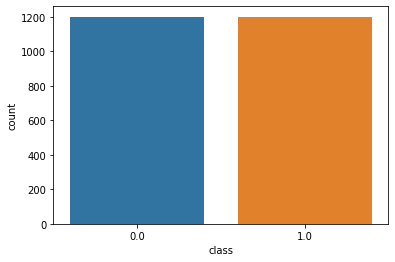

In [ ]:
# grab our seaborn visualization toolbox!
import seaborn as sns
print(metadata.groupby(['class']).count())
### YOUR CODE HERE
sns.countplot(x = 'class', data = metadata)
### END CODE

We split our data into different 'sets' that each will work differently with our machine learning model. 

Think of our AI as a machine learning 'student'. 

**Training Set:** Our training set is like a training manual. Our algorithm will read, or 'train', on this over and over again to try and learn its task. 

**Test Set:** Our test set is like a test. It is testing our model on problems that it has not seen before. 

**We usually have a much larger training set than test set. Let's see if this is the case with our data!**


Notice that our 'split' designation is found in the metadata. Plot the count of each 'set' in our data below:

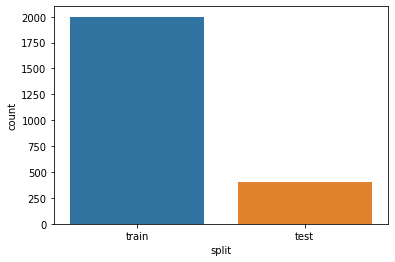

In [ ]:
### YOUR CODE HERE
metadata.groupby(['split']).count()
sns.countplot(x = 'split', data = metadata)
### END CODE

We are also interested in how many of each 'class' (PNEUMONIA or NORMAL) we have in each 'split' (train or test)
group by set and count the classes: for example, how many of the Training Set images are pneumonia?

Try this out with your group! Some hints:
* If you use `.groupby()` along with `count()`, you can pass in a list of different variables.
* You can plot the count and add another variable called `hue` to be either `class` or `split` using the structure below:
```
sns.countplot(x = 'column_name', hue = column_name, = data_table)
```


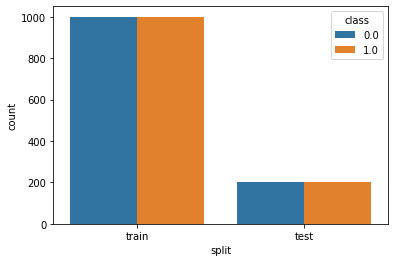

In [ ]:
### YOUR CODE HERE
metadata.groupby(['class','split']).count()
sns.countplot(x = 'split', hue = 'class',data =metadata)
### END CODE

## Activity 2b. What does our data look like? 

Now, let's take a look at the data itself!

**Question: What format do you think our data are in?** 

Discuss this with your group!



### Exercise (Coding)

We will check what we think the data is against what python tells us it is. Let's start by loading in the data and the labels:


In [ ]:
train_data, train_labels = get_train_data()

Try printing out `train_data.shape` and `train_labels.shape`. Can you explain the results?

In [ ]:
#YOUR CODE HERE
print(train_data.shape)
print(train_labels.shape)

(2000, 64, 64, 3)
(2000,)


Now, let's look at a single image! Below, the outputs help us understand: **what kind of data is `image`? What are its dimensions? What is its label?**

In [ ]:
image = train_data[0]
image_label = train_labels[0]

print('Our image is stored as %s in Python'%type(image))
print('Our image has dimensions of (%d, %d, %d)'%image.shape)
print('Our image has label %d'%image_label)

Our image is stored as <class 'numpy.ndarray'> in Python
Our image has dimensions of (64, 64, 3)
Our image has label 0


In [ ]:
#@title What does image shape represent? { display-mode: "form" }

#@markdown What does the bold number (**64**, 64, 3) represent? 
Dimension_0  = "image height" #@param ["Your answer", "image width", "image height","number of colors"]

#@markdown What does the bold number (64, **64**, 3) represent? 
Dimension_1  = "image width" #@param ["Your answer", "image width", "image height","number of colors"]
  
#@markdown What does the bold number (64, 64, **3**) represent? 
Dimension_2  = "number of colors" #@param ["Your answer", "image width", "image height","number of colors"]

if Dimension_0 == 'image height':
  print("Yes! Dimension_0 is the height of the image.")
else:
  print("Try again for Dimension_0!")

if Dimension_1 == 'image width':
  print("Yes! Dimension_1 is the width of the image.")
else:
  print("Try again for Dimension_1!")
  
if Dimension_2 == 'number of colors':
  print("Yes! Dimension_2 stands for 3 colors - (r,g,b).")
else:
  print("Try again for Dimension_2!")


Yes! Dimension_0 is the height of the image.
Yes! Dimension_1 is the width of the image.
Yes! Dimension_2 stands for 3 colors - (r,g,b).


**Visualize single image with plot_one_image**

Remember our `plot_one_image` function from last week? We'll use that with our data to view our images! Let's see a single image. 

`plot_one_image` can take in either one image or many images. To use it with one image that is 3D, call:

```
plot_one_image(image)
```

To use it with many images, call:


```
plot_one_image(data, labels, index)
```

where:
* `data`: all of our images in one array
* `labels`: the labels corresponding to the images
* `index`: which image we want to see


Label: 1.0


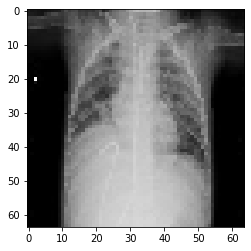

In [ ]:
# plot a SINGLE image
### YOUR CODE HERE
plot_one_image(train_data, train_labels,203)

### END CODE

###Exercise (Coding)     

Let's visualize a few more images from our data! 

Label: 0.0


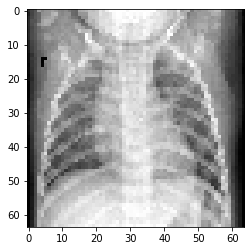

Label: 0.0


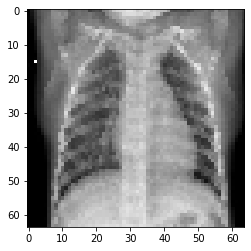

Label: 1.0


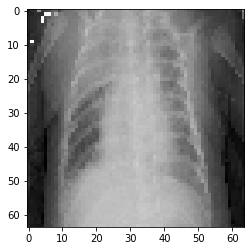

Label: 0.0


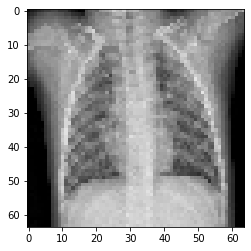

Label: 1.0


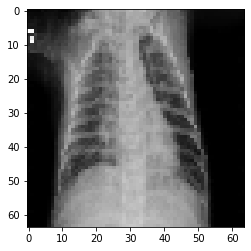

Label: 1.0


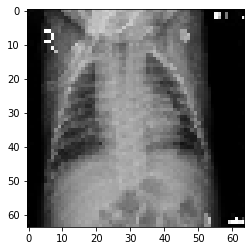

In [ ]:
# use a for loop to visualize more images
for i in range(6):
  plot_one_image(train_data, train_labels,i)
### YOUR CODE HERE

### END CODE

**Discuss:** How can **you** spot differences between PNEUMONIA and NORMAL images?

**Optional:** We might want to look at several PNEUMONIA and NORMAL images **separately**. Modify your for loop to visualize JUST PNEUMONIA and then JUST NORMAL images. 

Label: 1.0


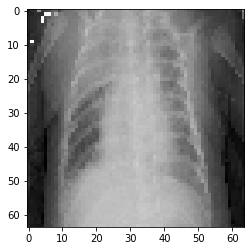

Label: 1.0


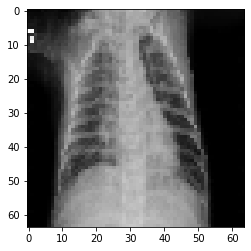

Label: 1.0


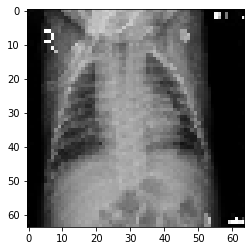

Label: 1.0


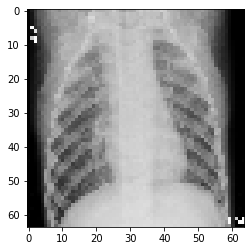

Label: 1.0


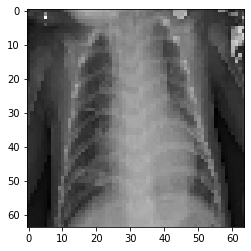

Label: 0.0


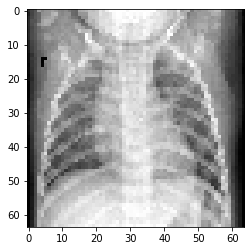

Label: 0.0


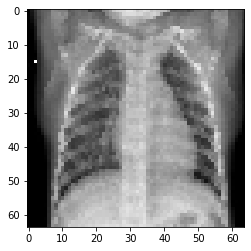

Label: 0.0


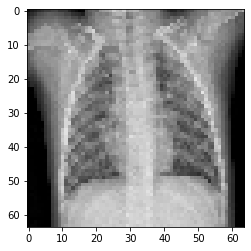

Label: 0.0


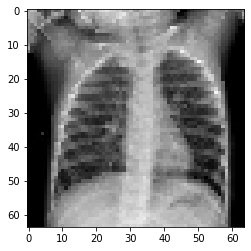

Label: 0.0


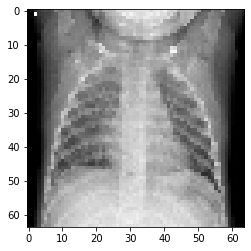

In [ ]:
from pandas.core.common import count_not_none
# use a loop to visualize just PNEUMONIA images
count_p = 0
i = 0
while count_p < 5 and i < 20:
  if train_labels[i] == 1:
    plot_one_image(train_data, train_labels, i)
    count_p += 1
  i += 1
### YOUR CODE HERE
count_n = 0
j = 0
while count_n < 5 and j < 20:
  if train_labels[j] == 0:
    plot_one_image(train_data, train_labels, j)
    count_n += 1
  j += 1
### END CODE

## Activity 2c. Fun with manipulating images

In this section, we'll practice some techniques for working with image data.


### Exercise (Coding)



Like we saw, an image is a 3D array with (y_location, x_location, rgb). Another way of saying this is that an image is a STACK of color matrices. Let's make this more tangible by creating a fake "mini" image!

**Notice that we're using a scale of 0 to 1 instead of 0 to 255.**

In [ ]:
import numpy as np

tiny_image = np.array([[[1, 0, 0],
                       [0, 0, 1]],
                      [[0, 1, 0],
                       [.5, .5, .5]]])
print (tiny_image)
print ("Dimensions: ", tiny_image.shape)

[[[1.  0.  0. ]
  [0.  0.  1. ]]

 [[0.  1.  0. ]
  [0.5 0.5 0.5]]]
Dimensions:  (2, 2, 3)


**How many pixels are in our image? What does each number mean?**

Let's plot our tiny image! Do the colors match what you expected?



Label: 


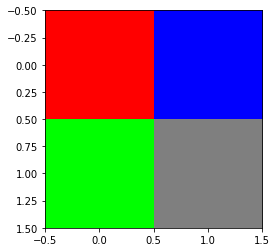

In [ ]:
plot_one_image(tiny_image)

**Experiment with changing the numbers to change your tiny image!**

What happens if we "slice" like this?

In [ ]:
tiny_image[1,:,:]

array([[0. , 1. , 0. ],
       [0.5, 0.5, 0.5]])

Let's try changing one of the color dimensions:

In [ ]:
new_image = tiny_image.copy() #make a copy so we don't change the original
new_image[:,:,0] = 0

What did this do? Visualize it!!


Label: 


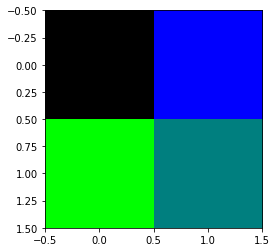

In [ ]:
### YOUR CODE HERE
plot_one_image(new_image)
### END CODE

Now, try to create a blue version of your image. This is know as **tinting.**

(Hint: Zero out the non-blue channels of the image.)

Label: 


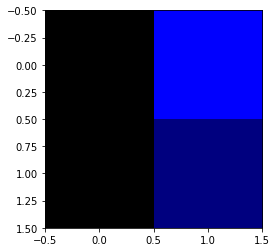

In [ ]:
### YOUR CODE HERE
new_image = tiny_image.copy()
new_image[:,:,0] = 0
new_image[:,:,1] = 0
plot_one_image(new_image)
### END CODE

### Exercise (Coding)

You've probably used an image crop before, where you segment part of an image out, like below. We will work on coloring a rectangle on your image.

![](https://ppom.nmediahosting.com/wp-content/uploads/2013/06/cropping.jpg)

The first step to doing this is identifying a rectangle in the image. Let's try to color a rectangle in our `rect_image`. 

Label: 


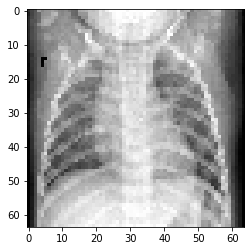

In [ ]:
rect_image = image.copy()
plot_one_image(rect_image)

You can access a pixel at the location (5, 5) in the image like this:


In [ ]:
rect_image[5,5]

array([0.5137255, 0.5137255, 0.5137255], dtype=float32)

How would you print the amount of **red** at this pixel?

In [ ]:
#YOUR CODE HERE
rect_image[5,5,0]

0.5137255

You can change the color the same way! For example:

```
rect_image[5,5,0] = 0.5
```

Try making a **single** pixel in our image bright red.

Label: 


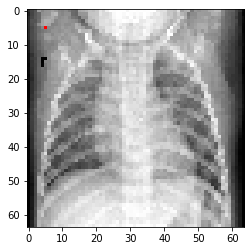

In [ ]:
#YOUR CODE HERE
rect_image[5,5,0] = 1
rect_image[5,5,1] = 0
rect_image[5,5,2] = 0
plot_one_image(rect_image)

**Challenge:** With this in mind, can you write a for loop to draw a red rectangle on our image? 

Label: 


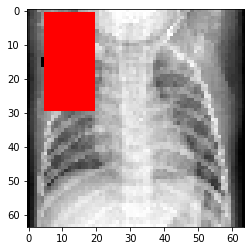

In [ ]:
### YOUR CODE HERE
start_x = 5
x_location = 20
start_y = 1
y_location = 30
new_color = [1, 0, 0]

rect_image = np.copy(image)
for j in range(start_x, x_location):
  for i in range(start_y, y_location):
      rect_image[i,j] = new_color

plot_one_image(rect_image)
### END CODE


# Milestone 3. Applying Machine Learning to Pneumonia Prediction

Now that we have experience working with image data, let's start planning our machine learning approach!


## Activity 3a. Defining our machine learning problem

Before we build our model, we have to identify what kind of problem it will solve and what data it's going to use. 

### Exercise (Discussion) 

What WILL our model look like? Remember, in machine learning, we always identify **inputs** and **outputs**. Our goal is to predict **outputs** from **inputs** with either **classification** or **regression**.

In **classification**, our output is a category (like dogs or cats). 

In **regression**, our output is a value (like 0, 0.1, 0.3, 100, ...). 

In [ ]:
#@title How will our model operate? { display-mode: "form" }

#@markdown What are our inputs? 
inputs = "images" #@param ["Your answer","pneumonia vs. normal", "images", "image edges", "probability of pneumonia vs. normal"]

#@markdown What are our outputs? 
outputs = "pneumonia vs. normal" #@param ["Your answer","pneumonia vs. normal", "images", "image edges", "probability of pneumonia vs. normal"]

#@markdown What kind of problem will our AI model solve? 
problem_type  = "classification" #@param ["Your answer", "classification", "regression"]


if inputs == "images":
  print("Yes, our inputs are our images!")
else:
  print('Not quite our inputs.')

if outputs == "pneumonia vs. normal":
  print("Yes, our outputs are pneumonia vs. normal!")
else:
  print('Not quite our outputs.')
  
if problem_type == "classification":
  print("We are trying to predict labels, therefore this is classification!")
else:
  print('Not quite our problem!')

Yes, our inputs are our images!
Yes, our outputs are pneumonia vs. normal!
We are trying to predict labels, therefore this is classification!


## Activity 3b. Building and evaluating models

### Exercise (Coding)


Today, we'll use some of the Scikit-learn approaches you've seen before. You'll build classifiers on your dataset and see how well you do! 

Sklearn takes in 'flat' data: that is, data that looks like a table, and is just samples x features. We'll need to **flatten** our 64 x 64 x 3 images, like this:

In [ ]:
(train_data, train_labels) = get_train_data(flatten = True)

Can you print out and explain the **shape** of  `train_data` and `train_labels`?

In [ ]:
#YOUR CODE HERE
print(train_data.shape)
print(train_labels.shape)

(2000, 12288)
(2000,)


Please get `test_data` ready the same way, using `get_test_data`:

In [ ]:
#YOUR CODE HERE
(test_data, test_labels)=get_test_data(flatten = True)

###Creating Baseline Models

We've tried a few models in sklearn since last week. Below, we list them with some sample parameters:
* `knn = KNeighborsClassifier(n_neighbors = 5)`
* `log = LogisticRegression(max_iter = 1000)`
* `dt = DecisionTreeClassifier(max_depth = 2)`
* others you can find [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) (try MLPClassifier!)

Please **try out a few models**, following each step of the machine learning pipeline:
- Set up a model
- Train (fit) your model
- Predict
- Score using `accuracy_score`

*Hint:* Check out the Conscientious Cars notebook for examples!


**Try to build the best model that you can!** 

Vary the parameters of your code. 

In [ ]:
#Set up, train, predict, and score!
### USE AS MANY CELLS AS YOU WANT!
knn = KNeighborsClassifier(n_neighbors = 5)
log = LogisticRegression(max_iter = 1000)
dt = DecisionTreeClassifier(max_depth = 2)


knn.fit(train_data,train_labels)
log.fit(train_data,train_labels)
dt.fit(train_data,train_labels)


pred_knn=knn.predict(test_data)
knn_accuracy=accuracy_score(test_labels,pred_knn)
print(knn_accuracy)

pred_log=log.predict(test_data)
log_accuracy=accuracy_score(test_labels,pred_log)
print(log_accuracy)

pred_dt=dt.predict(test_data)
dt_accuracy=accuracy_score(test_labels,pred_dt)
print( dt_accuracy) 


0.7025
0.6775
0.6575


**Discuss:** Are these results good enough for medical use? How could we improve them?

# Congratulations on completing your baseline model!


![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)